<h1>  Build agentic AI application using Langgraph </h1>
<p> Built by Jakob Lindstrøm, aka DataJakob@Github,  for Lumos  SDC. </p>
<p> In this notebook  we will create a agentic chatbot that is especially good at Q&A for finance and portfolio generation </p> 

<h3> 1 Import libraries </h3>

In [2]:
# Enviroment 
import os

# Classes packages
from typing import Annotated
from typing import TypedDict
from pydantic import BaseModel, Field

# "Lang" packages
import langchain
import langgraph
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.prompts import ChatPromptTemplate
from langgraph.checkpoint.memory import MemorySaver

# Other
from analyze.data import PortofolioCloud
from analyze.optimizer import Optimized

# .env variables
my_api_key = os.getenv("OPENAI_API_KEY")

<h2> 2 State and classes </h2>

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    mission: str
    stocks: Annotated[list, add_messages]

class Mission(BaseModel):
    mission: str = Field(description="""
                         Answer with one word based on the user query:
                         - "append", if the user wants to append  the stock into the portfolio.
                         - "info"  if the user wants more info about a stock or something else.
                         - "analyze"  if  the user wants to analyze the current portfolio,
                         - "other", if nothing of the above is specified.
                        """)
    
class Filter(BaseModel):
    company: str = Field(description="""
                         Identify the Norwegian public listed company.
                         """)
    ticker: str = Field(description="""
                        Identify the financial ticker of the mentioned company. 
                        """)

<h2> 3 Model and Nodes </h2>

In [6]:
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    temperature=0,
    # api_key=my_api_key
)


def chatbot(system_message, user_message):
    """
    A general chatbot function that takes in a custom system and user message.
    """
    system_input = "You are chatbot specializing in financial advisory. " + str(system_message)
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_input),
    ])
    info_model = prompt | llm 
    response =  info_model.invoke({"user":user_message})
    return response.content

In [8]:
def navigator(state: State):
    """
    Function that identify the intention of the user
    """
    nav_model =  llm.with_structured_output(Mission)
    response = nav_model.invoke(state["messages"]).mission
    return {"mission": response}



def info(state: State):
    """
    Function that returns information about a public lsited company
    """
    nav_model =  llm.with_structured_output(Filter)
    company = nav_model.invoke(state["messages"]).company
    response = chatbot("""Be brief and concise and present""" + company +""" and its main operations.""",
                        state["messages"]
                        )
    print(state["messages"])
    print("leave here")
    return {"messages": response}


    
def stock_appender(state: State):
    """
    Function that filters down the user input and identify a ticker and adds it to a list
    """
    nav_model =  llm.with_structured_output(Filter)
    ticker = nav_model.invoke(state["messages"]).ticker+".OL"
    response = chatbot("""You have just added a stock to a portfolio, ask the user if a new stock should be added.
                        Or if the user wants to get info about a company or  analyze the portfolio""",
                        state["messages"]
                        )
    return {"messages": response,
            "stocks":ticker}




def portfolio_analyzer(state: State):
    """
    Function that takes in a portfolio generated through chat 
    and analyzes the optimal posistions according to the Sharpe ratio.
    """
    stocks = [x.content for x in state["stocks"]]
    alfa = PortofolioCloud(stocks)
    alfa.final_df()
    bravo = Optimized(alfa.stocks, alfa.df,
                    alfa.tot_cov_mat,alfa.neg_cov_mat,
                    alfa.returns, alfa.mean, alfa.std)
    bravo.PortofolioOptimizer()
    positions =  bravo.optimized_portofolios
    myStr = ""
    for i in range(0, len(stocks),1):
        myStr += str(stocks[i]+ " at " +str(round(positions[2][0][i]*100,1))+"%, ")
    response = chatbot("""Use this input from the user to inform the user about the stock posistion that would generate
                           the best portfolio based on the Sharpe ratio. Be brief and concise"""+myStr,
                            state["messages"]
                            )
    return {"messages": response}



def other(state: State):
    """
    Function that forces the user to give "valid" input to the graph
    """
    response = chatbot("""The user has given you a unrelated query, make the user give queries about appending stocks to a porfolio,
                        get information about a company or analyze a portfolio """,
                        state["messages"]
                        )
    return {"messages": response}



<h2> 4 Edges</h2>

In [9]:
def decision(state: State):
    """
    Function that takes the output from the nav node and decides what would be the next node.
    """
    if state["mission"] == "append":
        return "append"
    elif state["mission"] == "analyze":
        return  "analyze"
    elif state["mission"] == "info":
        return "info"
    else:
        return "other"

<h2> 5 Workflow Compilation </h2>

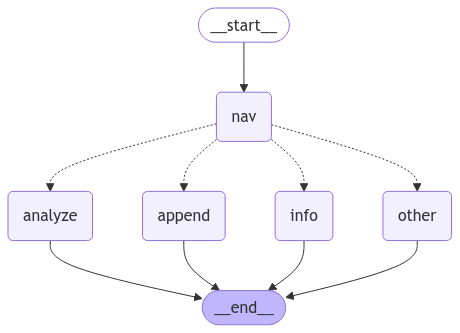

In [10]:
# Initialize the graph and create a memory saver
workflow = StateGraph(State)
memory = MemorySaver()

# Add nodes
workflow.add_node("nav", navigator)
workflow.add_node("info", info)
workflow.add_node("append", stock_appender)
workflow.add_node("analyze", portfolio_analyzer)
workflow.add_node("other", other)

# Add edges
workflow.add_edge(START, "nav")     # Non-optional move
workflow.add_conditional_edges("nav",   # Starting node
                               decision,    # Decider for which node to go to
                               # Options
                               {"info":"info",
                                "append":"append",
                                "analyze":"analyze",
                                "other":"other"}

)
workflow.add_edge("info", END)
workflow.add_edge("append", END)
workflow.add_edge("analyze", END)
workflow.add_edge("other", END)

# Compile and save the graph
# mygraph = workflow.compile(checkpointer=memory)
workflow.compile()

<h2> 6 Start chatting :) </h2>

In [14]:
def stream_graph_updates(user_input: str):
    for event in mygraph.stream({"messages": [("user", user_input)]},
                                {"configurable": {"thread_id": "0g"}}):
        for value in event.values():
            print("Assistant:", value)


while True:
    try:
        user_input = input("User: ")
        print(user_input)
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "----Something wong here------"    
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

give me info about equinor?
Assistant: {'mission': 'info'}
[HumanMessage(content='give me info about equinor?', additional_kwargs={}, response_metadata={}, id='0cb9a109-cc06-4085-89d4-22693031d646')]
leave here
Assistant: {'messages': 'Equinor ASA is a Norwegian multinational energy company primarily focused on oil, gas, and renewable energy. Formerly known as Statoil, it is state-owned and headquartered in Stavanger, Norway. \n\n**Main Operations:**\n1. **Oil and Gas Exploration and Production:** Equinor operates in several countries, including Norway, the UK, Brazil, and the US, focusing on offshore oil and gas fields.\n2. **Renewable Energy:** The company is investing heavily in renewable energy, particularly offshore wind and solar power, aiming to transition towards a more sustainable energy future.\n3. **Carbon Management:** Equinor is involved in carbon capture and storage (CCS) projects to reduce greenhouse gas emissions.\n\nEquinor aims to balance its portfolio between traditi

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Assistant: {'messages': "To optimize your portfolio based on the Sharpe ratio, consider the following allocation:\n\n1. **DNB.OL (57.6%)**: This stock is likely to provide a stable return, contributing positively to your overall risk-adjusted return.\n2. **MOWI.OL (42.4%)**: This stock can add growth potential and diversification to your portfolio.\n\nCurrently, holding **EQNR.OL at 0.0%** suggests you may want to reconsider its inclusion, as it does not contribute to your portfolio's performance. \n\nTo enhance your Sharpe ratio, focus on maintaining or slightly adjusting the allocations to DNB.OL and MOWI.OL based on their performance and market conditions. Regularly review your portfolio to ensure it aligns with your risk tolerance and investment goals."}
q
Goodbye!
